In [1]:
#1. Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications
import numpy as np
import os, datetime, pathlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# Run this each new runtime, this will save you a lot of time in training!
!unzip -u "/content/gdrive/MyDrive/roadcrack.zip" -d /content/roadcrack

Streaming output truncated to the last 5000 lines.
  inflating: /content/roadcrack/road crack/Positive/15001_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15002_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15003_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15004_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15005_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15006_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15007_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15008_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15009_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15010_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15011_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15012_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15013_1.jpg  
  inflating: /content/roadcrack/road crack/Positive/15014_1.jpg  
  inflating: /content/roa

In [4]:
#2. Data preparation
file_path = r"/content/roadcrack/road crack"
data_dir = pathlib.Path(file_path)

SEED = 12345
IMG_SIZE = (120,120)
BATCH_SIZE = 32

train_dataset = keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=SEED,shuffle=True,
                                                         image_size=IMG_SIZE,batch_size=BATCH_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='validation',seed=SEED,shuffle=True,
                                                         image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


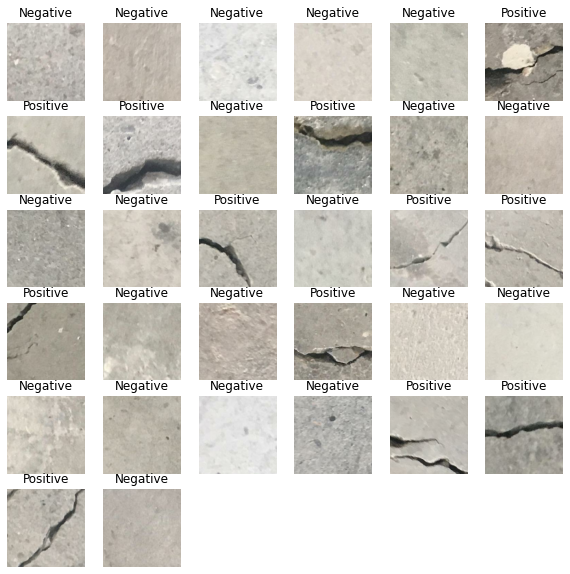

In [5]:
# Somesample of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.savefig('concrete_crack.png')
        plt.axis("off")

In [6]:
#Further split validation into validation-test splits
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)


#Create prefetch dataset for all the 3 splits
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# The data augmentation code is solely for reference purpose.
# We are not going to use data augmentation in this model, because our training image is diverse enough.
# So we can save our time in data augmentation. 
# Just for info, formal data processing steps would be:
# Data augmentation --> Preprocessing --> Feature extraction (pretrained model) --> Classification

#3. Data augmentation layers
# data_augmentation = keras.Sequential()
# data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
# data_augmentation.add(layers.RandomRotation(0.25))

In [7]:
#4. Model creation

class_names = train_dataset.class_names
nClass = len(class_names)
IMG_SHAPE = IMG_SIZE + (3,)
global_avg = layers.GlobalAveragePooling2D()

inputs = keras.Input(shape=IMG_SHAPE)
h1 = layers.Conv2D(32, (3,3), padding = "same", activation='relu')
h2 = layers.Conv2D(16, (3,3), padding = "same", activation='relu')
h3 = layers.Conv2D(8, (3,3), padding = "same", activation='relu')

c1 = layers.Flatten()
c3 = layers.Dense(32, activation='relu')
c4 = layers.Dense(16, activation='relu')
out_layer = layers.Dense(nClass, activation='softmax')

# Chain the functional API
x = inputs / 255.0 #(preprocess)
x = h1(x) # feature extraction
x = h2(x)
x = h3(x)
x = global_avg(x) # downsizing
x = c1(x) 
x = c3(x)
x = c4(x)
outputs = out_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 120, 120, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 16)      4624      
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 8)       1160      
                                                                 
 global_average_pooling2d (G  (None, 8)                0         
 lobalAveragePooling2D)                                      

In [8]:
#7. Compile the model
optimizer = optimizers.Adam(learning_rate = 0.001)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [9]:
#8. Perform model training
EPOCHS = 2
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/2
1000/1000 [==============================] - 1111s 1s/step - loss: 0.3536 - accuracy: 0.7931 - val_loss: 0.0553 - val_accuracy: 0.9844
Epoch 2/2
1000/1000 [==============================] - 1101s 1s/step - loss: 0.0431 - accuracy: 0.9866 - val_loss: 0.0397 - val_accuracy: 0.9866


In [11]:
optimizer = optimizers.Adam(learning_rate = 0.0004)
history = model.fit(pf_train,validation_data=pf_val,epochs=1)

1000/1000 [==============================] - 1097s 1s/step - loss: 0.0347 - accuracy: 0.9886 - val_loss: 0.0262 - val_accuracy: 0.9911


In [12]:
optimizer = optimizers.Adam(learning_rate = 0.00015)
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/2
1000/1000 [==============================] - 1101s 1s/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 0.0305 - val_accuracy: 0.9887
Epoch 2/2
1000/1000 [==============================] - 1099s 1s/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.0212 - val_accuracy: 0.9937


In [13]:
optimizer = optimizers.Adam(learning_rate = 0.00007)
history = model.fit(pf_train,validation_data=pf_val,epochs=1)

1000/1000 [==============================] - 1100s 1s/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.0228 - val_accuracy: 0.9927


In [14]:
optimizer = optimizers.Adam(learning_rate = 0.00003)
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/2
1000/1000 [==============================] - 1097s 1s/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0188 - val_accuracy: 0.9939
Epoch 2/2
1000/1000 [==============================] - 1095s 1s/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0174 - val_accuracy: 0.9942


In [15]:
optimizer = optimizers.Adam(learning_rate = 0.000017)
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/2
1000/1000 [==============================] - 1097s 1s/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0132 - val_accuracy: 0.9966
Epoch 2/2
1000/1000 [==============================] - 1098s 1s/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0145 - val_accuracy: 0.9952


In [19]:
optimizer = optimizers.Adam(learning_rate = 0.000013)
history = model.fit(pf_train,validation_data=pf_val,epochs=1)

1000/1000 [==============================] - 1131s 1s/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0207 - val_accuracy: 0.9950


In [21]:
optimizer = optimizers.Adam(learning_rate = 0.000045)
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/2
1000/1000 [==============================] - 1133s 1s/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0212 - val_accuracy: 0.9923
Epoch 2/2
1000/1000 [==============================] - 1132s 1s/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0116 - val_accuracy: 0.9972


In [23]:
optimizer = optimizers.Adam(learning_rate = 0.000017)
history = model.fit(pf_train,validation_data=pf_val,epochs=1)

1000/1000 [==============================] - 1135s 1s/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0123 - val_accuracy: 0.9966


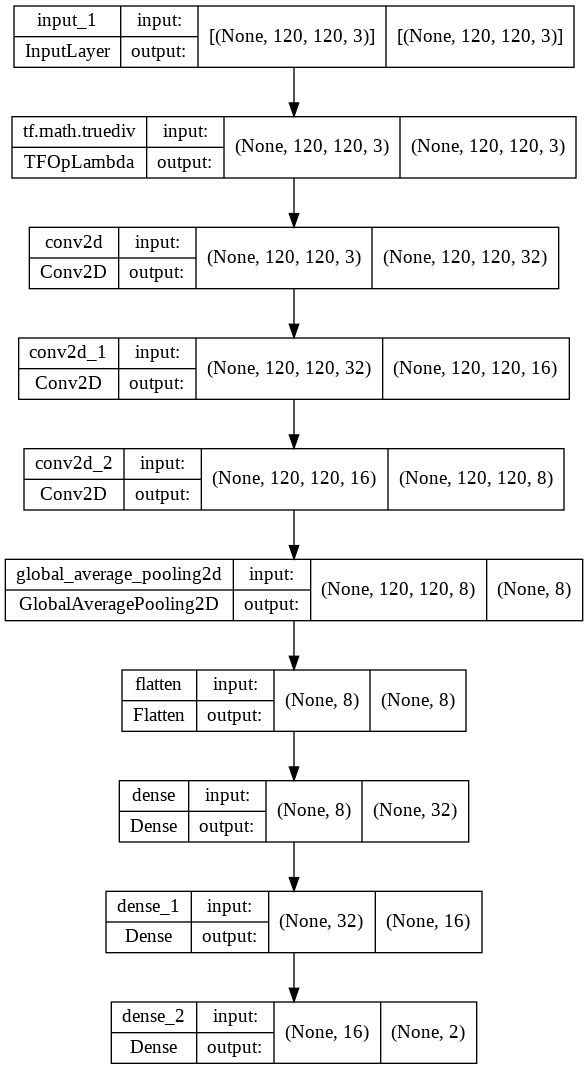

In [25]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [24]:
#Evaluate the model after training
test_loss, test_accuracy = model.evaluate(pf_test)

print("------------------------------After Training---------------------------")
print("Loss = ", test_loss)
print("Accuracy = ",test_accuracy)

50/50 [==============================] - 12s 242ms/step - loss: 0.0093 - accuracy: 0.9975
------------------------------After Training---------------------------
Loss =  0.009301889687776566
Accuracy =  0.9975000023841858


In [26]:
#Deploy the model to make predictions
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predictions = np.argmax(model.predict(image_batch),axis=1)

In [27]:
#Compare label vs prediction
label_vs_prediction = np.transpose(np.vstack((label_batch,predictions)))

In [28]:
print(label_vs_prediction)

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]]


In [29]:
#Print the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(label_batch,predictions))

[[12  0]
 [ 0 20]]


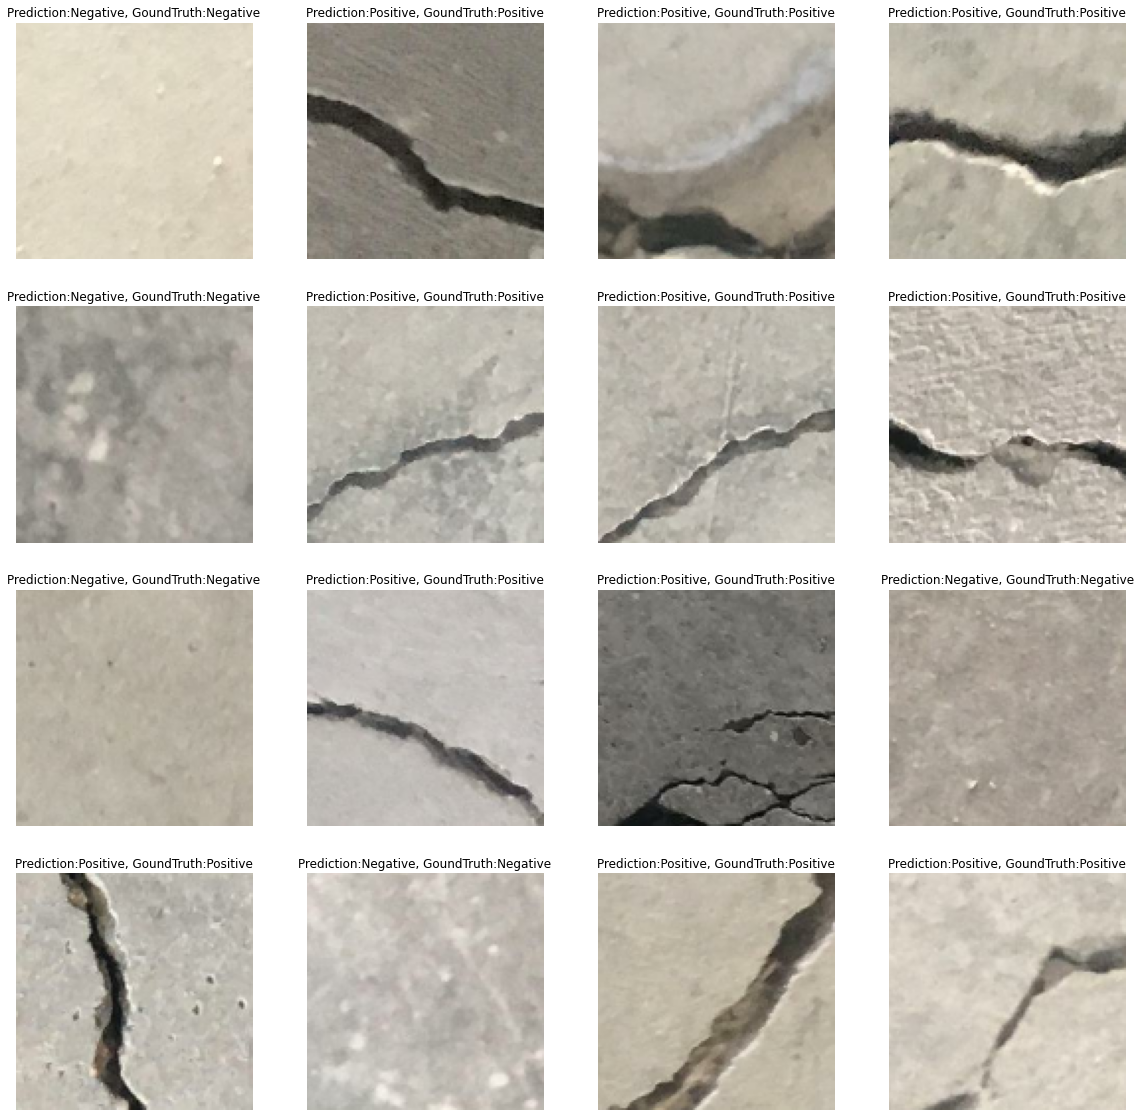

In [30]:
# Somesample of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
class_names = train_dataset.class_names
for images, labels in test_dataset.take(1):
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    a = class_names[np.argmax(model.predict(images),axis=1)[i]]
    b = class_names[labels[i]]
    plt.title(f"Prediction:{a}, GoundTruth:{b}")
    plt.savefig('concrete_crack.png')
    plt.axis("off")

In [31]:
model.save('Project_3_1.h5') 